## Analysis of principal actions (panel C)

In [1]:
from definitions import ROOT_DIR
import os
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from functions_notebook import make_parallel_envs,set_config
import pickle
from stable_baselines3.common.vec_env import VecNormalize
from sb3_contrib import RecurrentPPO
from envs.environment_factory import EnvironmentFactory
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

/opt/homebrew/Caskroom/miniforge/base/envs/myochallenge/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MyoSuite:> Registering Myo Envs


### A. Performance vs. number of dimensions removed in the action space

In [2]:
num_ep = 100
n_comp = 39

PATH_TO_NORMALIZED_ENV = os.path.join(
    ROOT_DIR,
    "trained_models/curriculum_steps_complete_baoding_winner/32_phase_2_smaller_rate_resume/env.pkl",
)
PATH_TO_PRETRAINED_NET = os.path.join(
    ROOT_DIR,
    "trained_models/curriculum_steps_complete_baoding_winner/32_phase_2_smaller_rate_resume/model.zip",
)

env_name = "CustomMyoBaodingBallsP2"
render = False

config = set_config(period=5,rot_dir="cw")
rollouts = []

envs = make_parallel_envs(env_name, config, num_env=1)
envs = VecNormalize.load(PATH_TO_NORMALIZED_ENV, envs)
envs.training = False
envs.norm_reward = False
custom_objects = {
    "learning_rate": lambda _: 0,
    "lr_schedule": lambda _: 0,
    "clip_range": lambda _: 0,
}
model = RecurrentPPO.load(
        PATH_TO_PRETRAINED_NET, env=envs, device="cpu", custom_objects=custom_objects
    )

eval_model = model
eval_env = EnvironmentFactory.create(env_name,**config)

MyoSuite:> Registering Myo Envs


/opt/homebrew/Caskroom/miniforge/base/envs/myochallenge/lib/python3.9/site-packages/stable_baselines3/common/save_util.py:166: UserWarning: Could not deserialize object _last_lstm_states. Consider using `custom_objects` argument to replace this object.
  warnings.warn(


1. Generate and save the actions. __Go to point 2. to directly load the previously-obtained data.__

In [ ]:
for n in range(num_ep):
    acts = []
    cum_reward = 0
    lstm_states = None
    obs = eval_env.reset()
    episode_starts = np.ones((1,), dtype=bool)
    done = False
    timestep = 0
    while not done: 
        if render :
            eval_env.sim.render(mode="window")
            
        timestep += 1
        action, lstm_states = eval_model.predict(envs.normalize_obs(obs),
                                                state=lstm_states,
                                                episode_start=episode_starts,
                                                deterministic=True,
                                                )
                                                    
        obs, rewards, done, info = eval_env.step(action)
        episode_starts = done
        cum_reward += rewards
        acts.append(action)
    print('episode %s : '%n,cum_reward)
    rollouts.append({'reward':cum_reward,'action':np.array(acts)})

# fp = os.path.join(ROOT_DIR, "data", "basecamp", "rollouts.pkl")
# fp_rollouts = open(fp, 'wb')
# pickle.dump(rollouts,fp_rollouts)
# fp_rollouts.close()

2. Load the actions

In [3]:
# Load the file from Basecamp : 'rollouts'
rollouts = pickle.load(open(os.path.join(ROOT_DIR, "data", "basecamp", "rollouts.pkl"),"rb"))


3. __Go to point 4. to directly load the previously-obtained data.__\
a. Compute the principal actions \
b. Compute the performance when the actions are projected on a progressively lower-dimensional action subspace\
c. Save the data

In [ ]:
actions = np.concatenate([rollout['action'] for rollout in rollouts])
performance = []
pca = PCA(n_components=n_comp).fit(actions)

for k in range(n_comp):
    print(k)
    components = pca.components_[:n_comp-k]
    performance_ep = []
    for n in range(num_ep):
        acts = []
        cum_reward = 0
        lstm_states = None
        obs = eval_env.reset()
        episode_starts = np.ones((1,), dtype=bool)
        done = False
        timestep = 0
        while not done: 
            if render :
                eval_env.sim.render(mode="window")
                
            timestep += 1
            action, lstm_states = eval_model.predict(envs.normalize_obs(obs),
                                                    state=lstm_states,
                                                    episode_start=episode_starts,
                                                    deterministic=True,
                                                    )
            
            action_proj = np.dot(action.reshape(-1,39)-pca.mean_,components.T)
            action_backproj = np.dot(action_proj,components)+pca.mean_
            obs, rewards, done, info = eval_env.step(action_backproj.reshape(39,))
            episode_starts = done
            cum_reward += rewards
        performance_ep.append(cum_reward)
    performance_ep = np.array(performance_ep) / 1000  # Transform the reward into the solved fraction
    performance.append({'components':components,'solved_frac_mean': np.mean(performance_ep), 'solved_frac_sem': np.std(performance_ep) / np.sqrt(len(performance_ep))})

# fp = os.path.join(ROOT_DIR, "data", "basecamp", "performance_action_components_t.pkl")
# fp_acts_pcs = open(fp, 'wb')
# pickle.dump(performance,fp_acts_pcs)
# fp_acts_pcs.close()

4. Load the performances vs. number of principal actions

In [5]:
# Load the file from Basecamp : 'performance_actions_components_t'
performance_components = pickle.load(open(os.path.join(ROOT_DIR, "data", "basecamp", "performance_action_components_t.pkl"),'rb'))
n_comp = 39

5. Plot the performance vs. number of dimensions removed in the action space

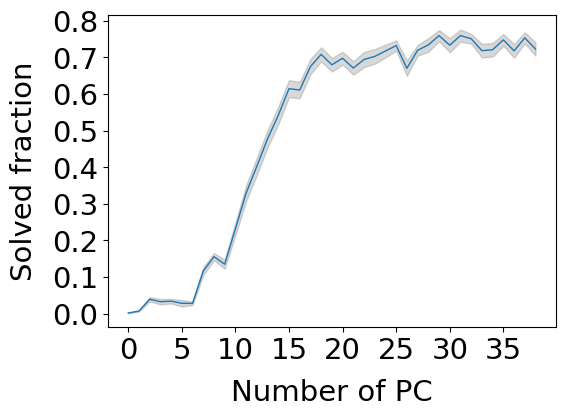

In [7]:
# TODO: should we also add the cumulative explained variance?
perfs_mean = np.array([d['solved_frac_mean'] for d in performance_components[::-1]])
perfs_sem = np.array([d['solved_frac_sem'] for d in performance_components[::-1]])

perfs_max = perfs_mean + perfs_sem
perfs_min = perfs_mean - perfs_sem
plt.plot(np.arange(n_comp), perfs_mean, linewidth=1)
plt.fill_between(np.arange(n_comp), perfs_min, perfs_max, color='gray', alpha=0.3, label='Standard Error')

plt.xlabel('Number of PC',fontsize=21,labelpad=10)
plt.ylabel('Solved fraction',fontsize=21,labelpad=10)
plt.yticks(fontsize=21)
plt.xticks(fontsize=21)
plt.subplots_adjust(left=0.2,bottom=0.23)
plt.savefig(os.path.join(ROOT_DIR, "data", "figures", "panel_3", "pca_performance_contrib.png"), format="png", dpi=600, bbox_inches="tight")
plt.show()

In [ ]:
# perfs = [d['reward'] for d in performance_components]
# comps = [d['components'] for d in performance_components]
# plt.plot([k for k in range(n_comp)],perfs,linewidth=1)
# plt.xlabel('Number of dimensions \nremoved in the action space',fontsize=21,labelpad=10)
# plt.ylabel('Solved fraction',fontsize=21,labelpad=10)
# plt.yticks(fontsize=21)
# plt.xticks(fontsize=21)
# plt.subplots_adjust(left=0.2,bottom=0.23)
# plt.show()

### B. Visualize the first principal actions
1. Load the principal actions

In [7]:
# Load the file from Basecamp : 'performance_actions_components_t'
performance_components = pickle.load(open(os.path.join(ROOT_DIR, "data", "basecamp", "performance_action_components_t.pkl"),'rb'))
principal_actions = [d['components'] for d in performance_components][0]

2. Save frames of each action

Creating offscreen glfw
Plotting component  0


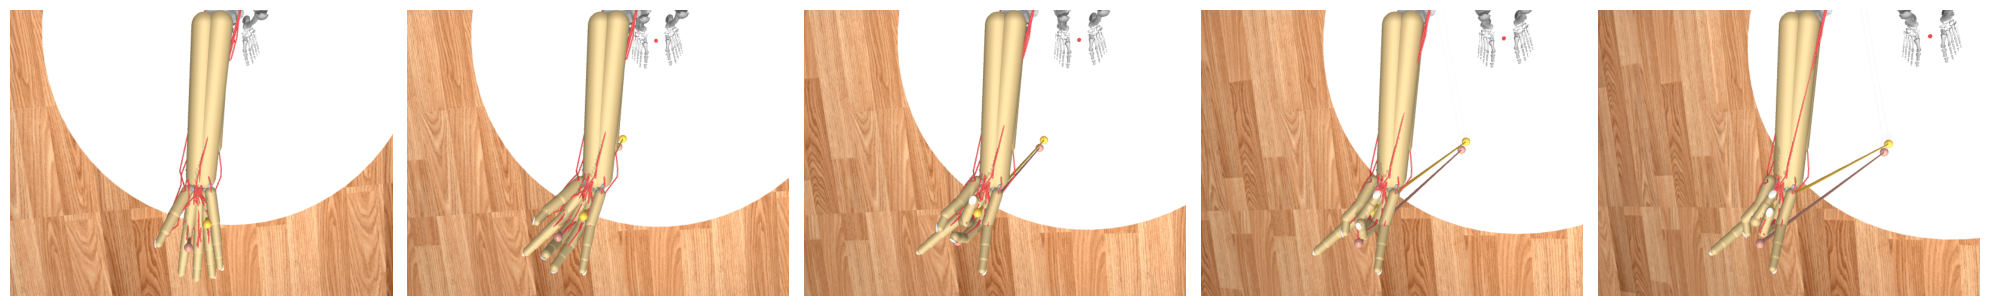

Creating offscreen glfw
Plotting component  1


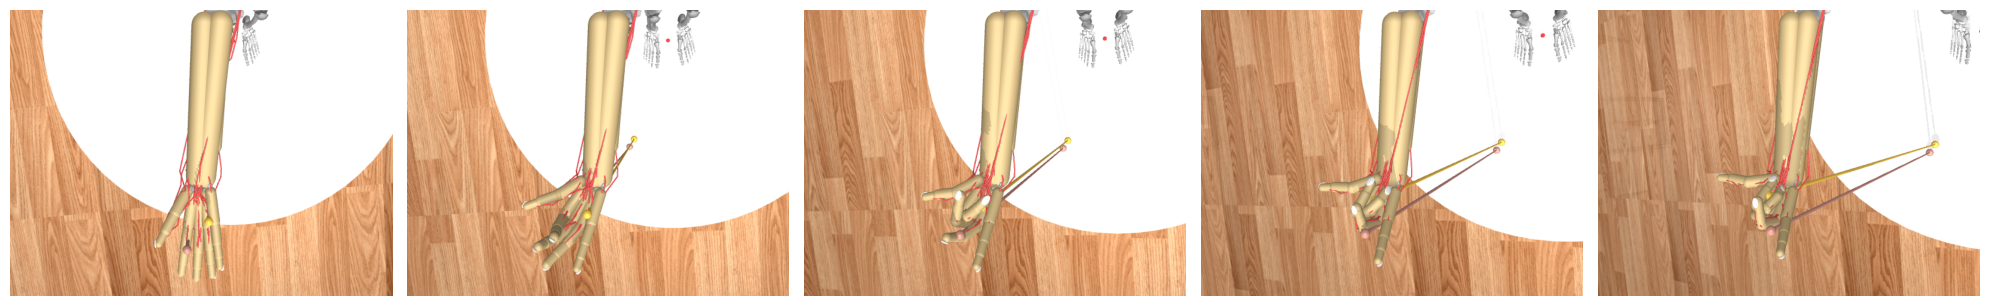

Creating offscreen glfw
Plotting component  2


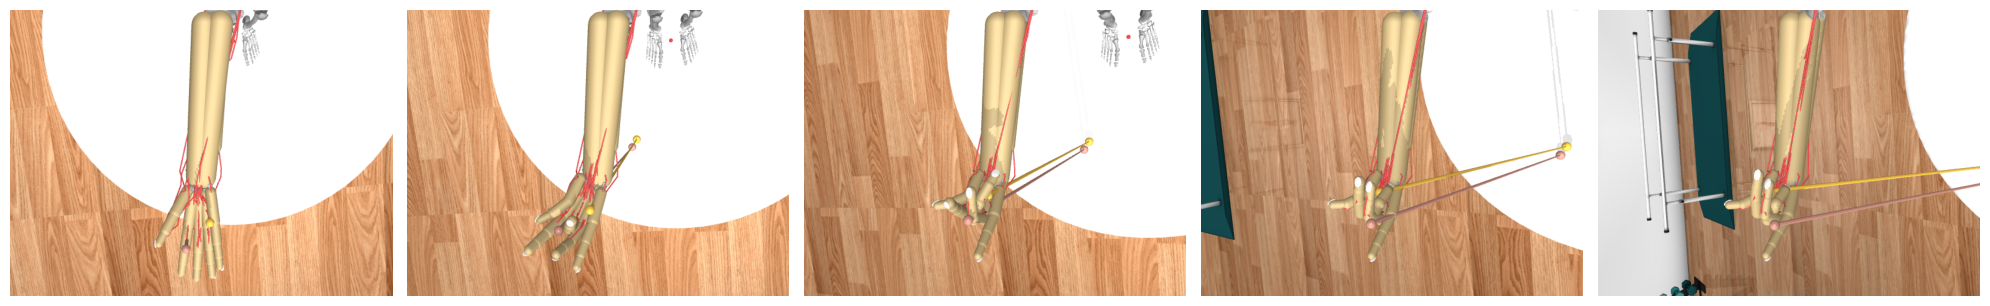

Creating offscreen glfw
Plotting component  3


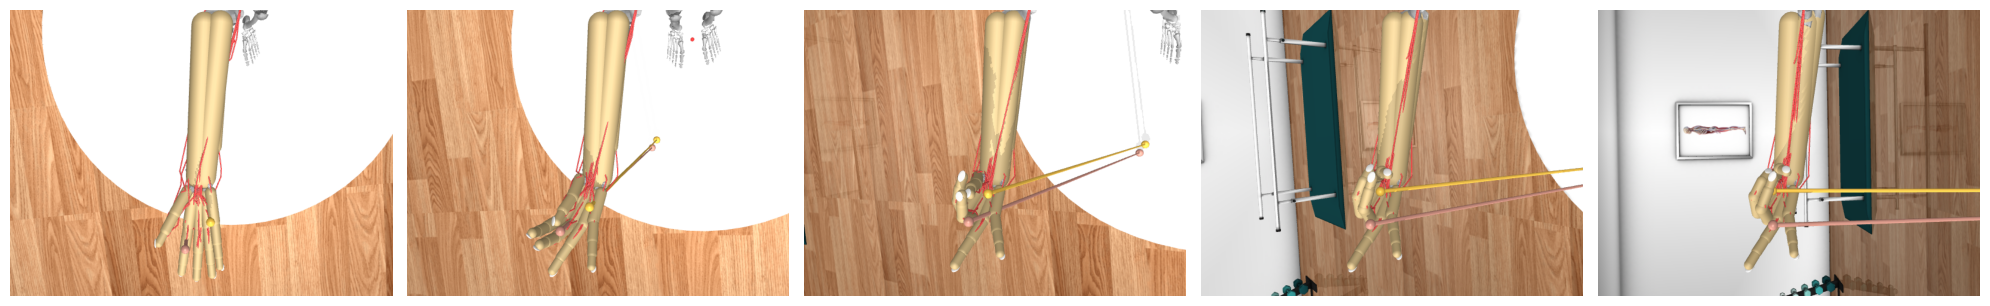

Creating offscreen glfw
Plotting component  4


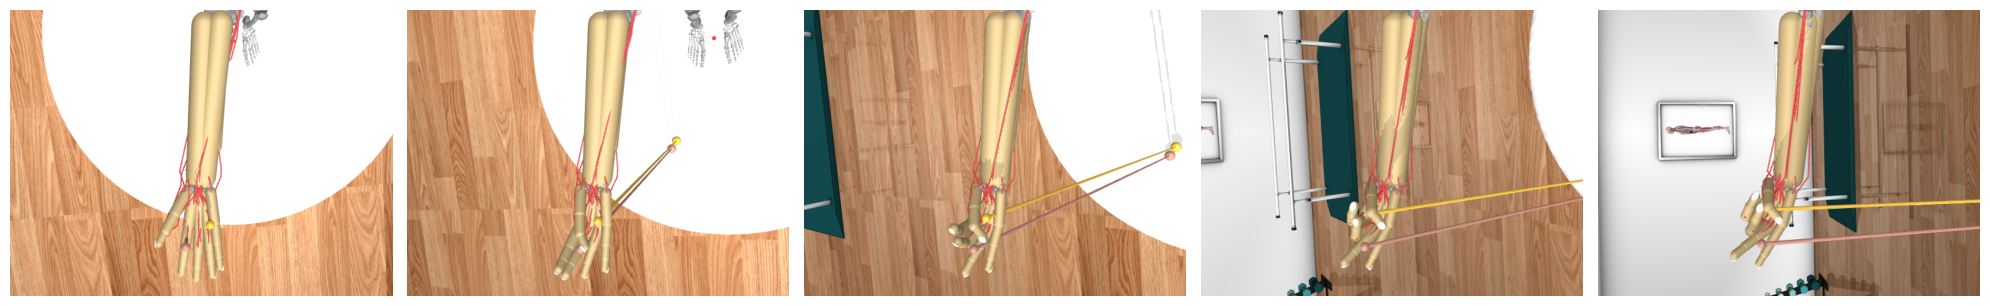

In [91]:
for action_idx in range(5):
    PATH_TO_NORMALIZED_ENV = os.path.join(
        ROOT_DIR,
        "trained_models/curriculum_steps_complete_baoding_winner/32_phase_2_smaller_rate_resume/env.pkl",
    )

    env_name = "CustomMyoBaodingBallsP2"

    config = set_config(period=5,rot_dir="cw")
    rollouts = []

    eval_env = EnvironmentFactory.create(env_name, **config)
    frames = []

    for n in range(1): # Just one episode
        eval_env.reset()
        qpos = eval_env.init_qpos.copy()
        qvel = eval_env.init_qvel.copy()
        qpos[25] = 0
        qpos[32] = 0
        eval_env.set_state(qpos, qvel)
        timestep = 0
        while timestep < 50 : 
            curr_frame = eval_env.render_camera_offscreen(['hand_top', 'hand_bottom', 'hand_side_inter', 'hand_side_exter', 'plam_lookat'])
            frames.append(curr_frame)
            timestep += 1
            obs, rewards, done, info = eval_env.step(principal_actions[action_idx])

    cam_frames = [l[1] for l in frames[::10]]
    num_frames = len(cam_frames)

    print("Plotting component ", action_idx)
    # Create a figure with a single row and the number of columns equal to the number of frames
    fig, axes = plt.subplots(1, num_frames, figsize=(num_frames * 4, 4))

    # Remove axes for all subplots
    for ax in axes:
        ax.axis('off')

    # Display each frame in its respective subplot
    for i, frame in enumerate(cam_frames):
        axes[i].imshow(frame)

    plt.tight_layout()  # Adjust spacing between subplots
    plt.savefig(os.path.join(ROOT_DIR, "data", "figures", "panel_3", f"principal_component_{action_idx}_frames.png"), format="png", dpi=600, bbox_inches="tight")
    plt.show()


### C. Heatmap of principal actions

1. Load the principal actions (same data as that generated in point A.3.and loaded in point A.4.) 

In [8]:
# Load the file from Basecamp : 'performance_actions_components_t'
performance_components = pickle.load(open(os.path.join(ROOT_DIR, "data", "basecamp", "performance_action_components_t.pkl"),'rb'))
principal_actions = [d['components'] for d in performance_components][0]

2. Plot the heatmap

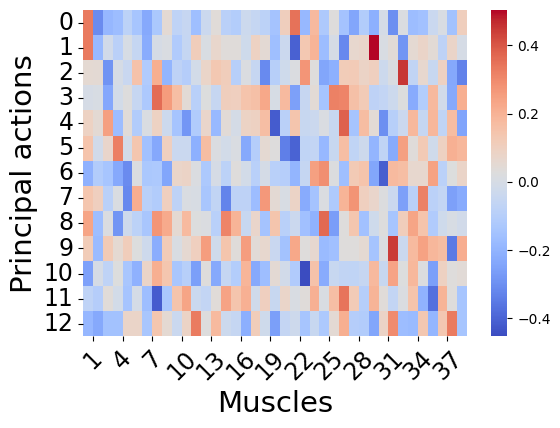

In [26]:
fig = sns.heatmap(pd.DataFrame(principal_actions[:13]),cmap="coolwarm").get_figure()
plt.xlabel('Muscles',fontsize=21)
plt.ylabel('Principal actions',fontsize=21)
plt.yticks(rotation=0,fontsize=17)
plt.xticks(ticks=np.arange(1,40,3),labels=np.arange(1,40,3),rotation=45,fontsize=17)
plt.subplots_adjust(left=0.15,bottom=0.2)
plt.savefig(os.path.join(ROOT_DIR, "data", "figures", "panel_3", "principal_components_muscle_weights.png"), format="png", dpi=600, bbox_inches="tight")
plt.show()

### D. Principal action vs. phase of rotation (time step)

1. Generate and save the actions. __Go to point 2. to directly load the previously-obtained data.__

In [ ]:
num_ep = 100
n_comp = 39

PATH_TO_NORMALIZED_ENV = os.path.join(
    ROOT_DIR,
    "trained_models/curriculum_steps_complete_baoding_winner/32_phase_2_smaller_rate_resume/env.pkl",
)
PATH_TO_PRETRAINED_NET = os.path.join(
    ROOT_DIR,
    "trained_models/curriculum_steps_complete_baoding_winner/32_phase_2_smaller_rate_resume/model.zip",
)

env_name = "CustomMyoBaodingBallsP2"
render = False

config = set_config(period=5,rot_dir="cw")
rollouts = []

envs = make_parallel_envs(env_name, config, num_env=1)
envs = VecNormalize.load(PATH_TO_NORMALIZED_ENV, envs)
envs.training = False
envs.norm_reward = False
custom_objects = {
    "learning_rate": lambda _: 0,
    "lr_schedule": lambda _: 0,
    "clip_range": lambda _: 0,
}
model = RecurrentPPO.load(
        PATH_TO_PRETRAINED_NET, env=envs, device="cpu", custom_objects=custom_objects
    )

eval_model = model
eval_env = EnvironmentFactory.create(env_name,**config)
actions = []
for n in range(num_ep):
    print(n)
    acts_1ep = []
    cum_reward = 0
    lstm_states = None
    obs = eval_env.reset()
    episode_starts = np.ones((1,), dtype=bool)
    done = False
    timestep = 0
    while not done: 
        if render :
            eval_env.sim.render(mode="window")
            
        timestep += 1
        action, lstm_states = eval_model.predict(envs.normalize_obs(obs),
                                                state=lstm_states,
                                                episode_start=episode_starts,
                                                deterministic=True,
                                                )
                                                    
        obs, rewards, done, info = eval_env.step(action)
        episode_starts = done
        cum_reward += rewards   
        acts_1ep.append(action)
    if len(acts_1ep) < 200 :
        temp = np.zeros((200,39))
        temp[:len(acts_1ep)] += acts_1ep
        acts_1ep = temp
    actions.append(np.array(acts_1ep))

'''fp = ""
fp_rollouts = open(fp, 'wb')
pickle.dump(actions,fp_rollouts)
fp_rollouts.close()'''

2. Load the actions

In [10]:
# Load the file from Basecamp : 'rollout_100ep'
actions = pickle.load(open(os.path.join(ROOT_DIR, "data", "basecamp", "rollout_100ep"),'rb'))
n_comp = 39

3. a. Compute the average principal actions \
b. Plot the PAs weights vs. time for the rotation phase

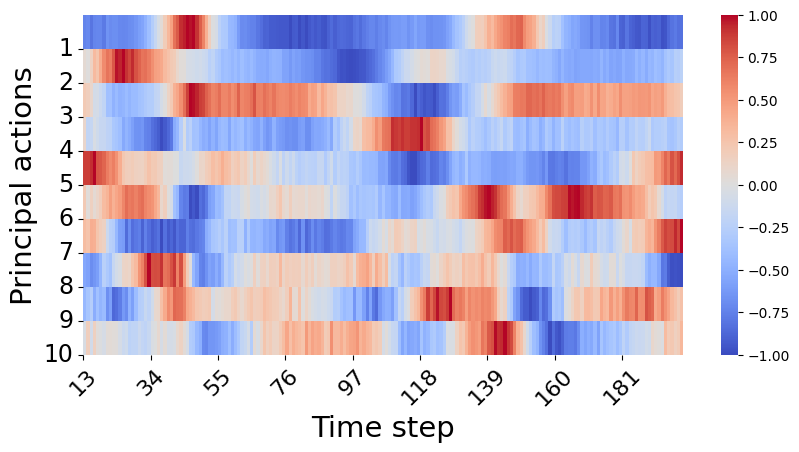

In [24]:
num_components_plot = 10
t_min = 13; t_max = 200 # Rotation phase (transient phase from 0 to 13 time steps)

pca = PCA(n_components=n_comp)
mean_actions = sum(actions)/len(actions)
mean_weights = pca.fit_transform(mean_actions)

minmax = MinMaxScaler(feature_range=(-1,1))
weights=[]
for j in range(num_components_plot):
    norm_weights = minmax.fit_transform(mean_weights[t_min:,j].reshape(t_max-t_min,1))
    weights.append(norm_weights)

fig, ax = plt.subplots(figsize=(10, 5)) 
sns.heatmap(pd.DataFrame(np.squeeze(weights)),cmap="coolwarm", ax=ax)
plt.yticks(ticks=np.arange(1,num_components_plot + 1,1),labels=np.arange(1,num_components_plot + 1,1),rotation=0,fontsize=17)
plt.xticks(rotation=45,ticks=np.arange(0,t_max-t_min,21),labels=np.arange(t_min,t_max,21),fontsize=16)
plt.xlabel('Time step',fontsize=21)
plt.ylabel('Principal actions',fontsize=21)
plt.subplots_adjust(left=0.15,bottom=0.2)
plt.savefig(os.path.join(ROOT_DIR, "data", "figures", "panel_3", "principal_components_episode.png"), format="png", dpi=600, bbox_inches="tight")
plt.show()

### Save screenshot at different steps of the episode

In [88]:
num_ep = 1
n_comp = 39

PATH_TO_NORMALIZED_ENV = os.path.join(
    ROOT_DIR,
    "trained_models/curriculum_steps_complete_baoding_winner/32_phase_2_smaller_rate_resume/env.pkl",
)
PATH_TO_PRETRAINED_NET = os.path.join(
    ROOT_DIR,
    "trained_models/curriculum_steps_complete_baoding_winner/32_phase_2_smaller_rate_resume/model.zip",
)

env_name = "CustomMyoBaodingBallsP2"
render = False

config = set_config(period=5,rot_dir="cw")
rollouts = []

envs = make_parallel_envs(env_name, config, num_env=1)
envs = VecNormalize.load(PATH_TO_NORMALIZED_ENV, envs)
envs.training = False
envs.norm_reward = False
custom_objects = {
    "learning_rate": lambda _: 0,
    "lr_schedule": lambda _: 0,
    "clip_range": lambda _: 0,
}
model = RecurrentPPO.load(
        PATH_TO_PRETRAINED_NET, env=envs, device="cpu", custom_objects=custom_objects
    )

eval_model = model
eval_env = EnvironmentFactory.create(env_name,**config)
frames = []
for n in range(num_ep):
    print(n)
    cum_reward = 0
    lstm_states = None
    obs = eval_env.reset()
    episode_starts = np.ones((1,), dtype=bool)
    done = False
    timestep = 0
    while not done: 
        curr_frame = eval_env.render_camera_offscreen(['hand_top', 'hand_bottom', 'hand_side_inter', 'hand_side_exter', 'plam_lookat'])
        frames.append(curr_frame)            
        timestep += 1
        action, lstm_states = eval_model.predict(envs.normalize_obs(obs),
                                                state=lstm_states,
                                                episode_start=episode_starts,
                                                deterministic=True,
                                                )
                                                    
        obs, rewards, done, info = eval_env.step(action)
        episode_starts = done
        cum_reward += rewards   
    print(cum_reward)


MyoSuite:> Registering Myo Envs
0
Creating offscreen glfw
785.0


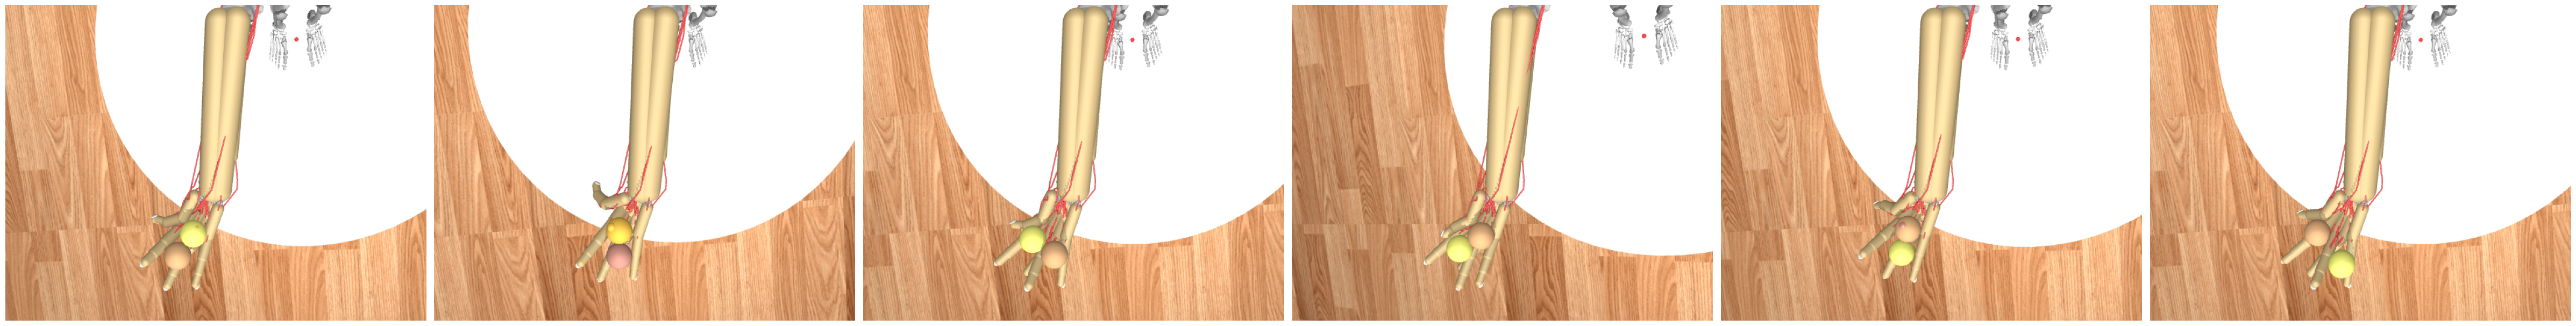

In [90]:
cam_frames = [l[1] for l in frames[20::30]]
num_frames = len(cam_frames)

# Create a figure with a single row and the number of columns equal to the number of frames
fig, axes = plt.subplots(1, num_frames, figsize=(num_frames * 8, 8))

# Remove axes for all subplots
for ax in axes:
    ax.axis('off')

# Display each frame in its respective subplot
for i, frame in enumerate(cam_frames):
    axes[i].imshow(frame)

plt.tight_layout()  # Adjust spacing between subplots
plt.savefig(os.path.join(ROOT_DIR, "data", "figures", "panel_3", f"episode_frames.png"), format="png", dpi=600, bbox_inches="tight")
plt.show()